In [4]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# Path to your tumor images
image_folder = "/kaggle/input/tumour-images/Tumour images"

# Preprocessing transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Custom dataset
class TumorImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        if self.transform:
            image = self.transform(image)
        return image

dataset = TumorImageDataset(image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


Using: cpu


In [5]:
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, features=64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features * 8, 4, 1, 0),
            nn.BatchNorm2d(features * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(features * 8, features * 4, 4, 2, 1),
            nn.BatchNorm2d(features * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(features * 4, features * 2, 4, 2, 1),
            nn.BatchNorm2d(features * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(features * 2, features, 4, 2, 1),
            nn.BatchNorm2d(features),
            nn.ReLU(True),
            nn.ConvTranspose2d(features, img_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels=1, features=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, features, kernel_size=4, stride=2, padding=1),   # 128 → 64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1),    # 64 → 32
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1),  # 32 → 16
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 4, features * 8, kernel_size=4, stride=2, padding=1),  # 16 → 8
            nn.BatchNorm2d(features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 8, 1, kernel_size=4, stride=1, padding=0),  # 8 → 5
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x).view(x.size(0), -1).mean(dim=1)  # → shape: [batch_size]


In [6]:
disc = Discriminator().to(device)

In [7]:
# Hyperparameters
z_dim = 100
lr = 2e-4
epochs = 50

# Initialize
gen = Generator(z_dim=z_dim).to(device)
disc = Discriminator().to(device)

criterion = nn.BCELoss()
opt_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))


Epoch [1/50]  Loss D: 0.0494  Loss G: 5.8277
Epoch [2/50]  Loss D: 0.0050  Loss G: 7.0850
Epoch [3/50]  Loss D: 0.0031  Loss G: 7.6909
Epoch [4/50]  Loss D: 0.0022  Loss G: 7.5179
Epoch [5/50]  Loss D: 0.0017  Loss G: 7.6469
Epoch [6/50]  Loss D: 0.0013  Loss G: 7.8079
Epoch [7/50]  Loss D: 0.0013  Loss G: 7.9362
Epoch [8/50]  Loss D: 0.0018  Loss G: 8.2071
Epoch [9/50]  Loss D: 0.0010  Loss G: 8.3660
Epoch [10/50]  Loss D: 0.0023  Loss G: 8.5699


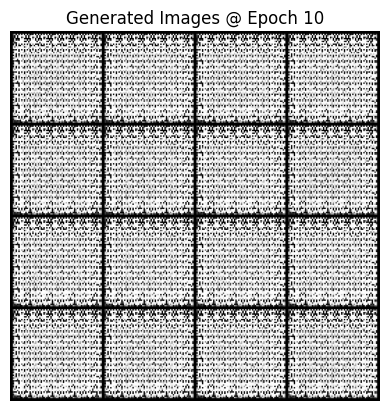

Epoch [11/50]  Loss D: 0.0007  Loss G: 8.4188
Epoch [12/50]  Loss D: 0.0012  Loss G: 9.0279
Epoch [13/50]  Loss D: 2.6593  Loss G: 10.9270
Epoch [14/50]  Loss D: 0.0714  Loss G: 7.8204
Epoch [15/50]  Loss D: 0.0138  Loss G: 5.8254
Epoch [16/50]  Loss D: 0.0131  Loss G: 6.7510
Epoch [17/50]  Loss D: 0.0162  Loss G: 7.5387
Epoch [18/50]  Loss D: 0.0263  Loss G: 8.9562
Epoch [19/50]  Loss D: 0.0080  Loss G: 6.9782
Epoch [20/50]  Loss D: 0.0046  Loss G: 8.5571


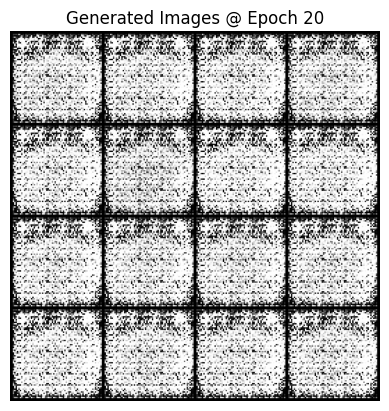

Epoch [21/50]  Loss D: 0.1930  Loss G: 2.9729
Epoch [22/50]  Loss D: 0.1637  Loss G: 7.7143
Epoch [23/50]  Loss D: 0.1029  Loss G: 3.8747
Epoch [24/50]  Loss D: 0.6589  Loss G: 6.0514
Epoch [25/50]  Loss D: 0.1350  Loss G: 9.6228
Epoch [26/50]  Loss D: 0.0597  Loss G: 3.1291
Epoch [27/50]  Loss D: 0.6940  Loss G: 4.5651
Epoch [28/50]  Loss D: 0.1074  Loss G: 4.2380
Epoch [29/50]  Loss D: 0.1373  Loss G: 4.1358
Epoch [30/50]  Loss D: 0.3217  Loss G: 6.1824


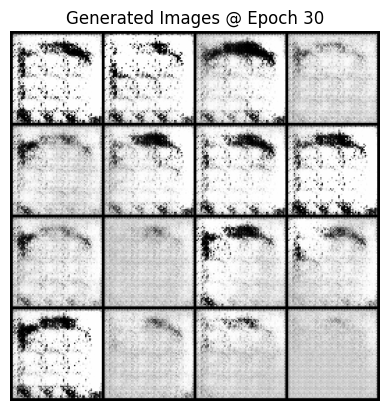

Epoch [31/50]  Loss D: 0.4260  Loss G: 3.3692
Epoch [32/50]  Loss D: 0.1612  Loss G: 3.6812
Epoch [33/50]  Loss D: 0.1873  Loss G: 3.9929
Epoch [34/50]  Loss D: 0.3692  Loss G: 5.0308
Epoch [35/50]  Loss D: 0.0773  Loss G: 4.8154
Epoch [36/50]  Loss D: 0.1940  Loss G: 4.1430
Epoch [37/50]  Loss D: 0.3466  Loss G: 4.3985
Epoch [38/50]  Loss D: 0.6656  Loss G: 4.6420
Epoch [39/50]  Loss D: 0.9399  Loss G: 4.0761
Epoch [40/50]  Loss D: 0.2014  Loss G: 3.6424


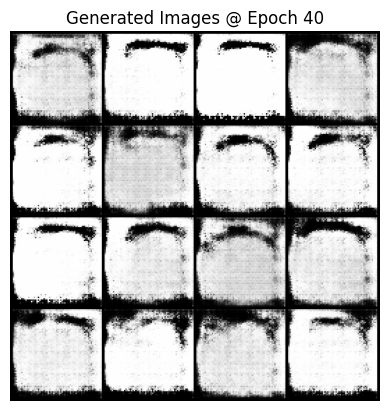

Epoch [41/50]  Loss D: 0.1519  Loss G: 3.9092
Epoch [42/50]  Loss D: 0.2913  Loss G: 3.1083
Epoch [43/50]  Loss D: 0.3516  Loss G: 4.9232
Epoch [44/50]  Loss D: 0.3191  Loss G: 2.7156
Epoch [45/50]  Loss D: 0.2838  Loss G: 4.9630
Epoch [46/50]  Loss D: 0.4430  Loss G: 2.4762
Epoch [47/50]  Loss D: 0.4498  Loss G: 3.2319
Epoch [48/50]  Loss D: 0.5531  Loss G: 1.6137
Epoch [49/50]  Loss D: 0.5028  Loss G: 3.4016
Epoch [50/50]  Loss D: 0.8006  Loss G: 4.5062


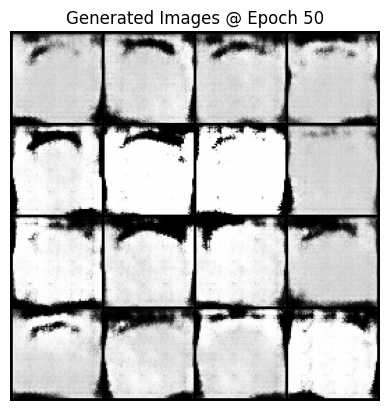

In [8]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for epoch in range(epochs):
    for batch in dataloader:
        real = batch.to(device)
        batch_size = real.size(0)

        # Labels
        label_real = torch.ones(batch_size).to(device)
        label_fake = torch.zeros(batch_size).to(device)

        # Train Discriminator
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)
        disc_real = disc(real)
        disc_fake = disc(fake.detach())
        loss_disc = (criterion(disc_real, label_real) + criterion(disc_fake, label_fake)) / 2

        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Train Generator
        output = disc(fake)
        loss_gen = criterion(output, label_real)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {loss_disc.item():.4f}  Loss G: {loss_gen.item():.4f}")

    # Optional: show preview
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            preview = gen(torch.randn(16, z_dim, 1, 1).to(device)).cpu()
            grid = make_grid(preview, normalize=True, nrow=4)
            plt.imshow(grid.permute(1, 2, 0))
            plt.title(f"Generated Images @ Epoch {epoch+1}")
            plt.axis('off')
            plt.show()
